## Impor Library

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow dan library lain berhasil diimpor.")

2025-06-13 11:51:58.320114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749815518.551097      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749815518.607216      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow dan library lain berhasil diimpor.


## Konfigurasi & Parameter

In [2]:
class Konfigurasi:
    # Pengaturan data
    IMG_WIDTH = 28
    IMG_HEIGHT = 28
    IMG_CHANNELS = 1

    # Pengaturan model
    # Coba ubah nilai ini (misal: 2, 8, 16) untuk melihat efeknya pada rekonstruksi & visualisasi
    LATENT_DIM = 32 
    
    # Pengaturan training
    EPOCHS = 25
    BATCH_SIZE = 128

config = Konfigurasi()
print("Konfigurasi proyek telah dimuat.")

Konfigurasi proyek telah dimuat.


## Memuat dan Mempersiapkan Dataset (Fashion MNIST)

In [3]:
# Memuat dataset Fashion MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalisasi piksel ke rentang [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape gambar untuk menambahkan channel (menjadi [samples, height, width, channels])
x_train = np.reshape(x_train, (len(x_train), config.IMG_HEIGHT, config.IMG_WIDTH, config.IMG_CHANNELS))
x_test = np.reshape(x_test, (len(x_test), config.IMG_HEIGHT, config.IMG_WIDTH, config.IMG_CHANNELS))

print("Dataset siap digunakan.")
print("Bentuk data training:", x_train.shape)
print("Bentuk data testing:", x_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dataset siap digunakan.
Bentuk data training: (60000, 28, 28, 1)
Bentuk data testing: (10000, 28, 28, 1)


## Membangun Arsitektur Model

In [10]:
# --- 1. ENCODER ---
input_img = Input(shape=(config.IMG_HEIGHT, config.IMG_WIDTH, config.IMG_CHANNELS), name='input_layer')

# Lapisan Konvolusi 1: 28x28 -> 14x14
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
# Lapisan Konvolusi 2: 14x14 -> 7x7
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# Lapisan Konvolusi 3: 7x7 -> 7x7 (tidak ada downsampling)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# Bentuk terenkripsi (representasi laten)
encoded = x # Output encoder sekarang berukuran 7x7x128

# Membuat model Encoder terpisah
encoder = Model(input_img, encoded, name='encoder')
encoder.summary()


# --- 2. DECODER ---
# Input decoder sekarang harus sesuai dengan output encoder
latent_input = Input(shape=(7, 7, 128), name='latent_input')

# Lapisan Dekonvolusi 1: 7x7 -> 14x14
# Kita gunakan strides=2 untuk upsampling sekaligus konvolusi
x = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(latent_input)
# Lapisan Dekonvolusi 2: 14x14 -> 28x28
x = Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
# Lapisan output untuk merekonstruksi gambar
# Layer ini memastikan output akhir berukuran 28x28 dengan 1 channel
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(x)

# Membuat model Decoder terpisah
decoder = Model(latent_input, decoded, name='decoder')
decoder.summary()


# --- 3. AUTOENCODER (Gabungan Encoder + Decoder) ---
autoencoder_output = decoder(encoder(input_img))
autoencoder = Model(input_img, autoencoder_output, name='autoencoder')

# Kompilasi model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,672 (362.00 KB)

 Trainable params: 92,672 (362.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ latent_input (InputLayer)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 14, 14, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,545 (361.50 KB)

 Trainable params: 92,545 (361.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 7, 7, 128)           │          92,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │          92,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 185,217 (723.50 KB)

 Trainable params: 185,217 (723.50 KB)

 Non-trainable params: 0 (0.00 B)

## Melatih Model Autoencoder

In [7]:
# Melatih model autoencoder
history = autoencoder.fit(
    x_train, x_train,
    epochs=config.EPOCHS,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/25


I0000 00:00:1749815702.534988      93 service.cc:148] XLA service 0x7dac0800f030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749815702.535748      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749815702.952987      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


 24/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.6383

I0000 00:00:1749815705.654077      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.3527 - val_loss: 0.2722
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2678 - val_loss: 0.2638
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2609 - val_loss: 0.2596
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2566 - val_loss: 0.2561
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2535 - val_loss: 0.2546
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2529 - val_loss: 0.2537
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2515 - val_loss: 0.2528
Epoch 8/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2504 - val_loss: 0.2522
Epoch 9/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2502 - val_loss: 0.2515
Epoch 10/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2489 - val_loss: 0.2512
Epoch 11/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2490 - val_loss: 0.2510
Epoch 12/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 

## Evaluasi Hasil Rekonstruksi

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


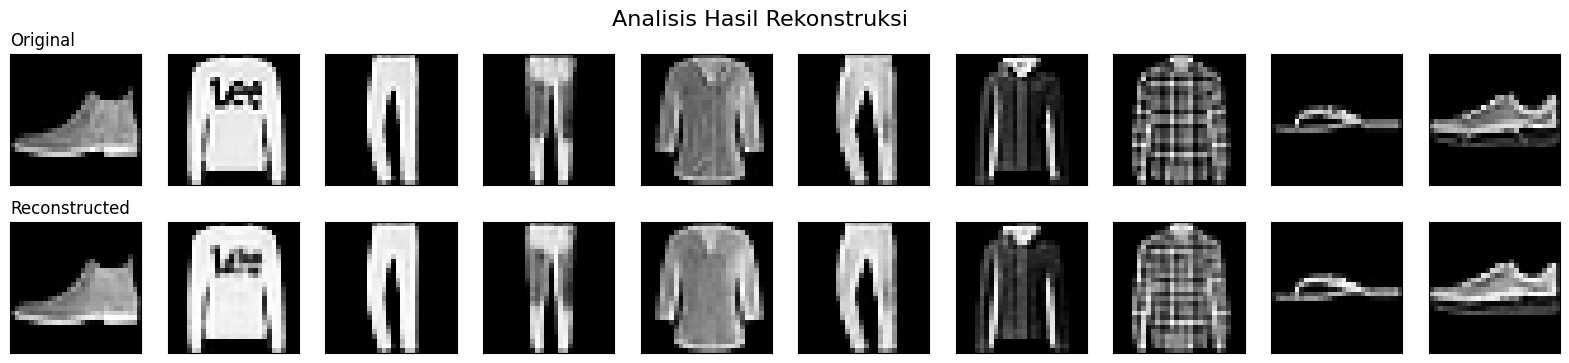

In [8]:
# Mendapatkan hasil rekonstruksi dari data tes
reconstructed_imgs = autoencoder.predict(x_test)

# Menampilkan perbandingan gambar asli dan hasil rekonstruksi
n = 10  # Jumlah gambar yang akan ditampilkan
plt.figure(figsize=(20, 4))
for i in range(n):
    # Tampilkan gambar asli
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Original", loc='left')

    # Tampilkan gambar hasil rekonstruksi
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Reconstructed", loc='left')
plt.suptitle("Analisis Hasil Rekonstruksi", fontsize=16)
plt.show()

## Eksplorasi Kreatif - Visualisasi Ruang Laten (Latent Space)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Bentuk ruang laten setelah di-flatten: (10000, 6272)


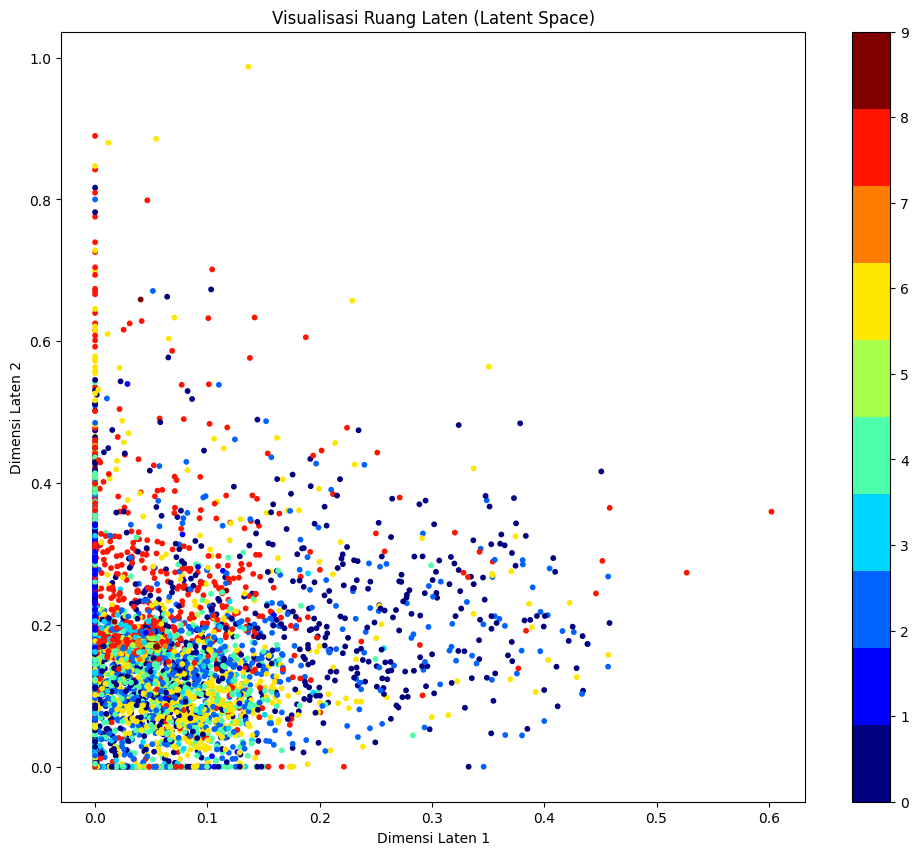

In [9]:
# Menggunakan encoder untuk mendapatkan representasi laten dari data tes
latent_representation = encoder.predict(x_test)

# Reshape agar bisa di-plot jika perlu (tergantung bentuk output encoder)
latent_flat = latent_representation.reshape((latent_representation.shape[0], -1))

print("Bentuk ruang laten setelah di-flatten:", latent_flat.shape)

plt.figure(figsize=(12, 10))
# 'y_test' berisi label asli (0=T-shirt, 1=Trouser, dst.)
# 'c=y_test' akan memberi warna berbeda untuk setiap kelas
# 'cmap=plt.cm.get_cmap("jet", 10)' membuat palet 10 warna
plt.scatter(latent_flat[:, 0], latent_flat[:, 1], c=y_test, cmap=plt.get_cmap("jet", 10), s=10)
plt.colorbar(ticks=range(10))
plt.title('Visualisasi Ruang Laten (Latent Space)')
plt.xlabel('Dimensi Laten 1')
plt.ylabel('Dimensi Laten 2')
plt.show()